In [21]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn.init as init

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
class CSVLabeledDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        self.features = self.data.iloc[:, :-1].values
        self.labels = self.data.iloc[:, -1].values

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        if self.transform:
            self.features = self.transform.fit_transform(self.features)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.features[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label
    
    def get_label_encoder(self):
        return self.label_encoder

In [23]:
def createDataLoader(train_csv, test_csv, batch_size=32):
    scaler = StandardScaler()

    train_dataset = CSVLabeledDataset(train_csv, transform=scaler)
    test_dataset = CSVLabeledDataset(test_csv, transform=scaler)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, test_dataset, train_loader, test_loader

In [24]:
# Arquivos CSV de treinamento e teste
train_csv = 'dataset/hars/train.csv'
test_csv = 'dataset/hars/test.csv'

train_dataset, test_dataset, train_loader, test_loader = createDataLoader(train_csv, test_csv)

In [25]:
# print(len(train_dataset), len(train_loader), len(test_loader))

In [26]:
for batch_idx, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 1, 562])
torch.Size([32])


In [27]:
class TemporalVAE(nn.Module):
    def __init__(self, device, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TemporalVAE, self).__init__()

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.2)
        self.output_layer = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.2)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std
    
    def encode(self, x):
        residual = x
        output, (h_n, _) = self.encoder_lstm(x)
        output = output[:, :, :output.size(2)//2] + output[:, :, output.size(2)//2:]
        h_n = output[:, -1, :]
        # h_n = h_n[-1, :, :]
        h_n = self.dropout(h_n)
        mean = torch.sigmoid(self.hidden2mean(h_n))
        logvar = torch.sigmoid(self.hidden2logvar(h_n))
        return mean, logvar, residual
    
    def decode(self, z, seq_len, residual):
        # hidden = self.latent2hidden(z).unsqueeze(0).repeat(seq_len, 1, 1).transpose(0, 1)
        hidden = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1)

        output, _ = self.decoder_lstm(hidden)
        output = self.dropout(output)

        # output += residual

        output = self.output_layer(output)
        return output
    
    def forward(self, x):
        mean, logvar, residual = self.encode(x)
        z = self.reparameterize(mean, logvar)
        seq_len = x.size(1)
        recon_x = self.decode(z, seq_len, residual)
        return recon_x, mean, logvar

In [28]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda
print(device)

input_dim = train_dataset.features.shape[1]
hidden_dim = 128 # 400
latent_dim = 64 # 20
num_layers = 2
epochs = 100

mps


In [29]:
# carregando modelo
model_path = "model/vae.pth"

# Criar uma instância do modelo
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)

# Carregar o estado salvo
state_dict = torch.load(model_path)

# Carregar o estado no modelo
model.load_state_dict(state_dict)

print(model)

TemporalVAE(
  (encoder_lstm): LSTM(562, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 562, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=562, out_features=562, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [30]:
# # Função para extrair vetores latentes
# def extract_latent_vectors(model, data_loader):
#     latents = []
#     labels = []
#     with torch.no_grad():
#         for data, label in data_loader:
#             data = data.to(device)
#             mean, logvar, _ = model.encode(data)
#             latents.append(mean.cpu().numpy())
#             labels.append(label.cpu().numpy())
#     return np.vstack(latents), np.hstack(labels)

# # Extrair vetores latentes
# train_latents, train_labels = extract_latent_vectors(model, train_loader)
# test_latents, test_labels = extract_latent_vectors(model, test_loader)

In [31]:
# print(train_latents.shape, test_latents.shape)
# print(train_latents)

(7352, 64) (2947, 64)
[[0.48585942 0.5011762  0.49068755 ... 0.47771725 0.49875984 0.47792423]
 [0.4990093  0.5117892  0.49116087 ... 0.5117176  0.41974252 0.54256684]
 [0.5136604  0.5096865  0.49176905 ... 0.48500267 0.5135598  0.50459266]
 ...
 [0.5035616  0.47917795 0.50967073 ... 0.4998727  0.5001191  0.496023  ]
 [0.49655455 0.49685454 0.5020224  ... 0.5536226  0.48680675 0.49211454]
 [0.49656808 0.54075027 0.49346778 ... 0.4781844  0.5178165  0.4898844 ]]


In [32]:
class Net(nn.Module):
    def __init__(self, model, input_dim):
        super(Net, self).__init__()
        self.encode = model

        # usando o encoder do VAE com espaco latente (acc ~ 78%)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 6)

        # (ERRADO) usando o encoder do VAE com residuo (acc ~ 90%)
        # self.latent2hidden = nn.Linear(64, 128)
        # self.decoder_lstm = nn.LSTM(128, input_dim, 6, batch_first=True, bidirectional=False, dropout=0.2)
        # self.output_layer = nn.Linear(input_dim, input_dim)
        # self.fc1 = nn.Linear(input_dim, 64)
        # self.dropout = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(64, 6)

        # (ERRADO) usando o VAE completo (acc ~ 95%)
        # self.fc1 = nn.Linear(input_dim, 64)
        # self.dropout = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(64, 6)

        # Freeze encoder parameters
        for param in model.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        # usando o encoder do VAE com espaco latente (acc ~ 78%)
        mean, logvar, residual = self.encode.encode(x)
        # print(mean)
        # z = self.encode.reparameterize(mean, logvar)
        # print(z.shape)
        x = torch.sigmoid(self.fc1(mean)) #  self.fc1(mean)
        x = self.dropout(x)
        x = self.fc2(x)

        # (ERRADO) usando encoder do VAE, somando o residuo e expandindo para o shape original (acc ~ 90%)
        # mean, logvar, residual = self.encode.encode(x)
        # z = self.encode.reparameterize(mean, logvar)
        # # print(z)
        # seq_len = x.size(1)
        # x = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1).view(z.size(0), -1)
        # x, _ = self.decoder_lstm(x)
        # x = self.dropout(x)
        # residual = residual.squeeze(1)
        # x += residual
        # x = self.output_layer(x)
        # x = torch.sigmoid(self.fc1(x)) #  self.fc1(mean)
        # x = self.dropout(x)
        # x = self.fc2(x)

        # print("mean output shape:", mean.shape)
        # print("logvar output shape:", logvar.shape)
        # print("residual output shape:", residual.shape)
        # print("z output shape:", z.shape)
        # print("seq_len output shape:", seq_len)
        # print("x output shape:", x.shape)
        # return

        # (ERRADO) usando o VAE completo (acc ~ 95%)
        # recon_x, mean, logvar = self.encode.forward(x)
        # # print(recon_x)
        # x = torch.sigmoid(self.fc1(recon_x.view(recon_x.size(0), -1))) #  self.fc1(mean)
        # x = self.dropout(x)
        # x = self.fc2(x)
        return x

In [33]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        init.zeros_(m.bias)

In [34]:
net = Net(model, input_dim=input_dim).to(device)
net.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

print(net)

Net(
  (encode): TemporalVAE(
    (encoder_lstm): LSTM(562, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
    (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
    (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
    (decoder_lstm): LSTM(128, 562, num_layers=2, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=562, out_features=562, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


In [35]:
def trainModel(model, train_loader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for x, y in train_loader:
    data = x.to(device)
    label = y.to(device)
    
    optimizer.zero_grad()
    logits = model(data)
    loss = criterion(logits, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = logits.max(1)
    total += label.size(0)
    correct += predicted.eq(label).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

def evalModel(model, val_loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for x, y in val_loader:
      data = x.to(device)
      label = y.to(device)
      logits = model(data)
      loss = criterion(logits, label)

      running_loss += loss.item()
      _, predicted = logits.max(1)
      total += label.size(0)
      correct += predicted.eq(label).sum().item()

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

In [36]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(epochs):
  train_loss, train_acc = trainModel(net, train_loader, criterion, optimizer, device)
  val_loss, val_acc = evalModel(net, test_loader, criterion, device)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

Epoch 1/100, Train Loss: 1.7888, Train Acc: 20.80, Val Loss: 1.7265, Val Acc: 20.26
Epoch 2/100, Train Loss: 1.6962, Train Acc: 27.75, Val Loss: 1.6377, Val Acc: 30.37
Epoch 3/100, Train Loss: 1.6018, Train Acc: 34.68, Val Loss: 1.5293, Val Acc: 47.91
Epoch 4/100, Train Loss: 1.4876, Train Acc: 41.38, Val Loss: 1.4010, Val Acc: 62.27
Epoch 5/100, Train Loss: 1.3856, Train Acc: 45.70, Val Loss: 1.3010, Val Acc: 66.78
Epoch 6/100, Train Loss: 1.3021, Train Acc: 48.87, Val Loss: 1.1969, Val Acc: 66.81
Epoch 7/100, Train Loss: 1.2177, Train Acc: 52.67, Val Loss: 1.1140, Val Acc: 76.79
Epoch 8/100, Train Loss: 1.1563, Train Acc: 54.37, Val Loss: 1.0641, Val Acc: 72.48
Epoch 9/100, Train Loss: 1.0941, Train Acc: 57.71, Val Loss: 0.9912, Val Acc: 80.01
Epoch 10/100, Train Loss: 1.0413, Train Acc: 59.87, Val Loss: 0.9403, Val Acc: 80.90
Epoch 11/100, Train Loss: 1.0057, Train Acc: 61.40, Val Loss: 0.8993, Val Acc: 80.15
Epoch 12/100, Train Loss: 0.9719, Train Acc: 61.40, Val Loss: 0.8689, Val 

In [37]:
# avaliando modelo sem augmentation
test_loss, test_acc = evalModel(net, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}') # Test Loss: 1.6467, Test Acc: 35.87

Test Loss: 0.4464, Test Acc: 84.09


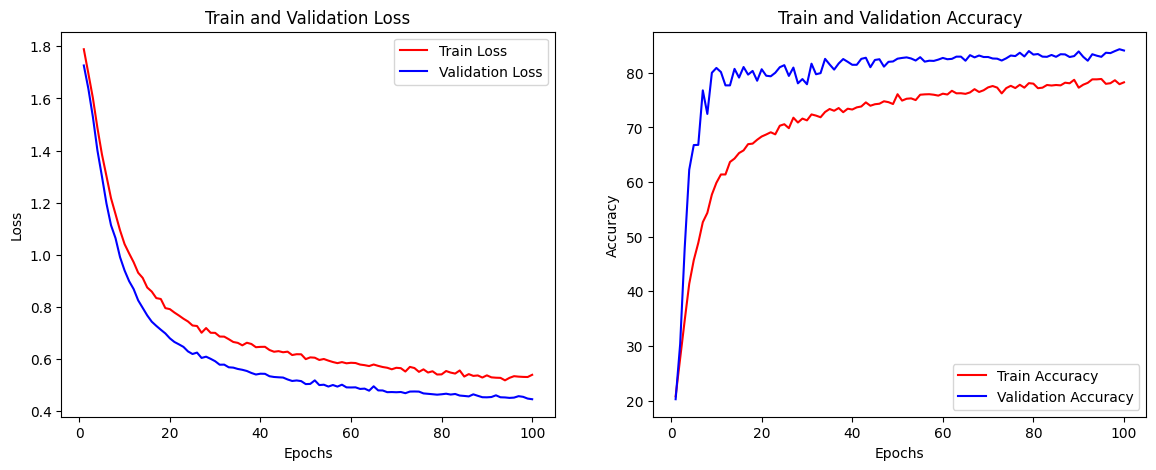

In [38]:
# Plotando a perda e a precisão do modelo sem augmentation
epocas = range(1, epochs + 1) # é 36 epocas porque com early stopping so rodou 36 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_losses, 'r', label='Train Loss')
plt.plot(epocas, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epocas, val_accuracies, 'b', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

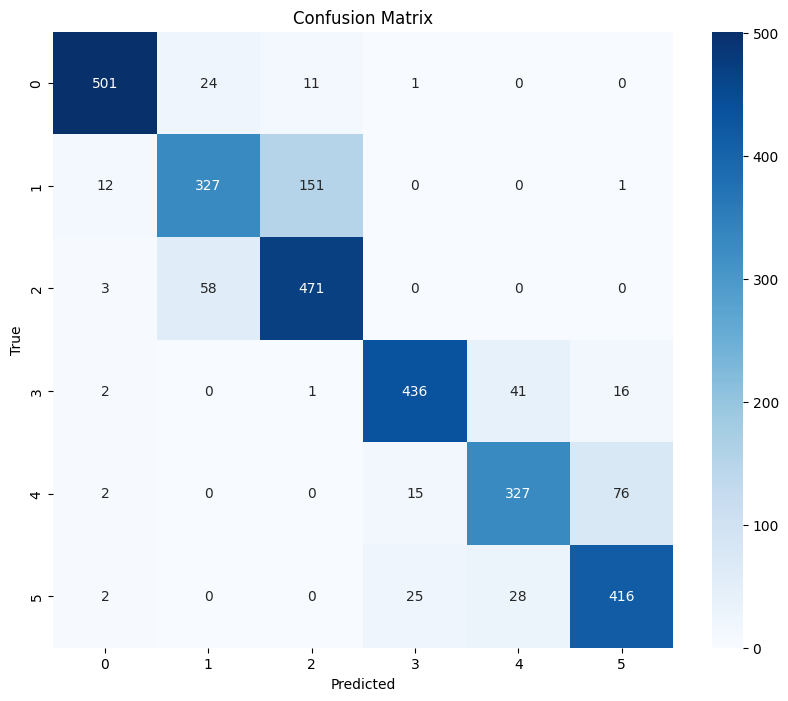

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       537
           1       0.80      0.67      0.73       491
           2       0.74      0.89      0.81       532
           3       0.91      0.88      0.90       496
           4       0.83      0.78      0.80       420
           5       0.82      0.88      0.85       471

    accuracy                           0.84      2947
   macro avg       0.84      0.84      0.84      2947
weighted avg       0.84      0.84      0.84      2947



In [39]:
# Obter previsões do conjunto de teste
net.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        data = x.to(device)
        label = y.to(device)
        outputs = net(data)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Calcular a matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print(classification_report(all_labels, all_preds))